# Compilation of linear optical circuits via KLM

We start by defining the non-linear sign gate from the KLM paper

In [1]:
from discopy.quantum.optics import Box, PRO, Matrix

class NS(Box):
    def __init__(self):
        super().__init__('NS', PRO(3), PRO(3))
        
    def dagger(self):
        return NS()
        
    @property
    def matrix(self):
        row1 = [1 - 2 ** .5 , 2 ** (-.25), ((3/2) ** .5 - 2) ** .5]
        row2 = [2 ** (-.25) , .5, .5 - .5 ** .5]
        row3 = [((3/2) ** .5 - 2) ** .5, .5 - .5 ** .5, 2 ** .5 - .5]
        return Matrix(self.dom, self.cod, [row1, row2, row3])

In [2]:
from discopy.quantum.optics import Id, create, annil, unit, counit, evaluate

nsign = Id(1) @ create @ unit >> NS() >> Id(1) @ annil @ counit
evaluate(nsign, [2], [2])

(-0.5+0j)

We can now build the KLM controlled-Z gate

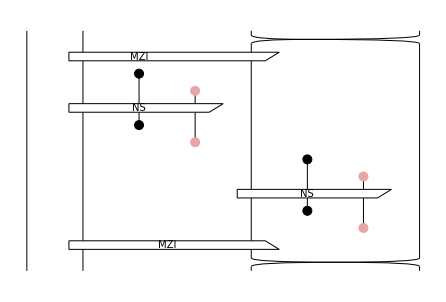

In [3]:
from discopy.quantum.optics import MZI
import numpy as np
np.set_printoptions(precision=1)

KLM_bs = MZI(.25, .5)
swap = Id(2).permute(1, 0)
KLM_cz = Id(2) @ swap >> Id(1) @ (KLM_bs >> nsign @ nsign >> KLM_bs.dagger()) @ Id(1) >> Id(2) @ swap

KLM_cz.draw(draw_type_labels=False)

In [4]:
def dual_rail_states(n_qubits):
    strings = []
    def genbin(n, bs=[]):
        if len(bs) == 2*n:
            strings.append(bs)
        else:
            genbin(n, bs + [1, 0])
            genbin(n, bs + [0, 1])
    genbin(n_qubits)
    return strings

dual_rail_states(2)
cz = np.array([[evaluate(KLM_cz, x, y) for x in dual_rail_states(2)] for y in dual_rail_states(2)])
print(cz)
print("Probability of success is: {}")

[[ 2.5e-01+0.0e+00j  0.0e+00+0.0e+00j  0.0e+00+0.0e+00j  0.0e+00+0.0e+00j]
 [ 0.0e+00+0.0e+00j  2.5e-01-3.9e-34j  0.0e+00+0.0e+00j  0.0e+00+0.0e+00j]
 [ 0.0e+00+0.0e+00j  0.0e+00+0.0e+00j  2.5e-01+3.1e-33j  0.0e+00+0.0e+00j]
 [ 0.0e+00+0.0e+00j  0.0e+00+0.0e+00j  3.1e-33+1.5e-33j -2.5e-01+2.3e-33j]]
Probability of success is: {}


Composing with hadamards (TBS(.25) in dual-rail encoding) we obtain the KLM controlled-NOT gate

In [5]:
from discopy.quantum.optics import TBS

KLM_cnot = Id(2) @ TBS(.25) >> KLM_cz >> Id(2) @ TBS(.25)
cnot = np.array([[evaluate(KLM_cnot, x, y) for x in dual_rail_states(2)] for y in dual_rail_states(2)])
print(cnot)

[[ 2.5e-01+1.5e-33j  7.1e-17+1.5e-33j  0.0e+00+0.0e+00j  0.0e+00+0.0e+00j]
 [-1.4e-17-1.9e-33j  2.5e-01+1.5e-33j  0.0e+00+0.0e+00j  0.0e+00+0.0e+00j]
 [ 0.0e+00+0.0e+00j  0.0e+00+0.0e+00j -1.0e-16-1.5e-33j  2.5e-01+1.4e-32j]
 [ 0.0e+00+0.0e+00j  0.0e+00+0.0e+00j  2.5e-01+8.5e-33j  2.1e-17+3.5e-33j]]


Construct a qubit circuit  

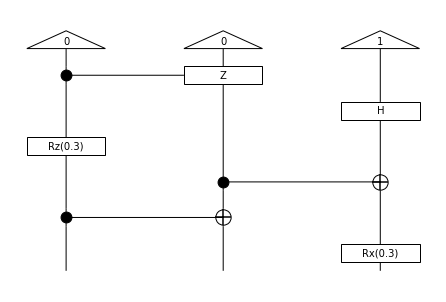

In [6]:
from discopy.quantum import CX, H, Id, Rz, Rx, CZ, Ket, Bra, qubit

circuit = Ket(0, 0, 1) >> CZ @ H >> Rz(0.3) @ CX >> CX @ Rx(0.3)
circuit.draw()

Map qubit circuits onto photonics using a Functor

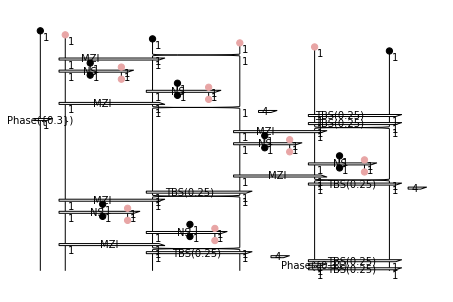

In [7]:
from discopy.quantum.optics import Scalar, Functor, Phase, Id

ob_KLM = {qubit: PRO(2)}

def ar_KLM(box):
    if box == H:
        return TBS(.25)
    if box == CX:
        return KLM_cnot @ Scalar(4)
    if box == CZ:
        return KLM_cz @ Scalar(4)
    if isinstance(box, Rz):
        return Phase(box.phase) @ Id(1)
    if isinstance(box, Rx):
        return TBS(.25) >> Phase(box.phase) @ Id(1) >> TBS(0.25)
    if isinstance(box, Ket):
        return Id().tensor(*[create @ unit if x == 0 else unit @ create for x in box.bitstring])
    if isinstance(box, Bra):
        return Id().tensor(*[annil @ counit if x == 0 else counit @ annil for x in box.bitstring])
    raise NotImplementedError()
    
KLM = Functor(ob_KLM, ar_KLM)
circ = KLM(circuit)
circ.draw()

Evaluate the amplitudes and check that they are equal to those of the qubit circuit, up to a global phase

In [8]:
states = dual_rail_states(len(circuit.cod))
array = np.array([evaluate(circ, [], y) for y in states])

In [9]:
assert np.allclose(np.abs(array.flatten()), np.abs(circuit.eval().array.flatten()))

Get compilation metrics

In [10]:
from discopy.quantum.optics import qpath_drag, make_square, Id, annil, create

bot, top, mid, scalar = qpath_drag(make_square(circ))
n_modes, n_photons = len(mid.dom), bot.boxes.count(create)
print('Number of modes: {}'.format(n_modes))
print('Number of input photons: {}'.format(n_photons))
print('Number of post-selected photons: {}'.format(top.boxes.count(annil)))
print('Normalisation scalar: {:.3f}'.format(scalar))
print('Probability of success: {}'.format((1 / scalar) ** 2))

Number of modes: 18
Number of input photons: 9
Number of post-selected photons: 6
Normalisation scalar: 64.000
Probability of success: 0.000244140625
